<a href="https://colab.research.google.com/github/Deok-Hun/Aiffel_Kun/blob/master/EX_8_%EB%84%A4%EC%9D%B4%EB%B2%84_%EC%98%81%ED%99%94%EB%A6%AC%EB%B7%B0_%EA%B0%90%EC%84%B1%EB%B6%84%EC%84%9D_%EB%8F%84%EC%A0%84%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://security.ubuntu.

In [3]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [4]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

Installing automake (A dependency for mecab-ko)
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists...
Reading

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 5.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  2014k      0 --:--:-- --:--:-- --:--:-- 2014k
./configure: line 7378: /usr/bin/file: No such file or directory
In file included from viterbi.cpp:14:0:
param.h:30:13: warning: 'Target {anonymous}::lexical_cast(Source) [with Target = std::__cxx11::basic_string<char>; Source = std::_

In [5]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.5
0.6.0
3.6.0


# 데이터 준비와 확인

In [6]:
import pandas as pd

# 데이터를 읽어온다.
train_data = pd.read_table('/content/drive/MyDrive/Exploration/Exploration_8/data/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Exploration/Exploration_8/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 데이터로더 구성

  * 데이터의 중복 제거
  * NaN 결측치 제거
  * 한국어 토크나이저로 토큰화
  * 불용어(Stopwords) 제거
  * 사전word_to_index 구성
  * 텍스트 스트링을 사전 인덱스 스트링으로 변환
  * X_train, y_train, X_test, y_test, word_to_index 리턴

In [7]:
# 실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면
# 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다.
# 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 
# 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다.
# data_loader 안에서는 다음을 수행해야 합니다.

In [8]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
  # 결측치 제거
  train_data.drop_duplicates(subset=['document'], inplace = True)
  train_data = train_data.dropna(how = 'any')
  test_data.drop_duplicates(subset=['document'],inplace = True)
  test_data = test_data.dropna(how = 'any')

  X_train = []
  for sentence in train_data['document']:
    temp_X = tokenizer.morphs(sentence)    # 토큰화(단어를 숫자로...)
    temp_X = [word for word in temp_X if not word in stopwords]   # 불용어 제거
    X_train.append(temp_X)


  X_test = []
  for sentence in test_data['document']:
    temp_X = tokenizer.morphs(sentence)    # 토큰화(단어를 숫자로...)
    temp_X = [word for word in temp_X if not word in stopwords]   # 불용어 제거
    X_test.append(temp_X)

  words = np.concatenate(X_train).tolist()
  counter = Counter(words)                 # 중복된 데이터가 몇 번씩 나오는지
  counter = counter.most_common(10000-4)   # 최반값 9996개 반환
  vocab = ['','','',''] + [key for key, _ in counter]
  word_to_index = {word:index for index, word in enumerate(vocab)}

  def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

  X_train = list(map(wordlist_to_indexlist, X_train))
  X_test = list(map(wordlist_to_indexlist, X_test))

  return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)  

In [9]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작한다.
def get_encoded_sentence(sentence,word_to_index):
  return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
  return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수.
def get_decoded_sentence(encoded_sentence, index_to_word):
  return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])
  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
  return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 모델 구성을 위한 데이터 분석 및 가공

  * 데이터셋 내 문장 길이 분포
  * 적절한 최대 문장 길이 지정
  * keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가

## 문장 길이 확인

In [11]:
print(X_train[0])             # 1번째 리뷰데이터
print('라벨: ', y_train[0])   # 1번째 리뷰데이터 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [12]:
decoded_sentences = get_decoded_sentences(X_train, index_to_word)
print(decoded_sentences[0:5])

['더 빙 . . 진짜 짜증 나 네요 목소리', '. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나', '재 ', '이야기 구먼 . . 솔직히 재미 없 다 . . 평점 조정', '익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던   너무나 이뻐 보였 다']


In [13]:
word_to_index = {k:(v+1) for k,v in word_to_index.items()}

word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])

<BOS>


## 최대 문장 길이 설정

In [14]:
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균: ',np.mean(num_tokens))
print('문장길이 최대: ',np.max(num_tokens))
print('문장길이 표준편차: ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 지정
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen: ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균:  15.96940191154864
문장길이 최대:  116
문장길이 표준편차:  12.843571191092
pad_sequences maxlen:  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


## 패딩 추가

In [15]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                     value = word_to_index["<PAD>"],
                                                     padding = 'pre',
                                                     maxlen = maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                     value = word_to_index["<PAD>"],
                                                     padding = 'pre',
                                                     maxlen = maxlen)

print(X_train.shape)
X_train[0]

(146182, 41)


array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  32,  74, 919,   4,   4,  39, 228,  20,
        33, 748], dtype=int32)

# 모델 구성 및 validation set 구성
  * RNN(LSTM)
  * 1-D CNN
  * GlobalMaxPooling

## train 및 validation 분리

In [17]:
from sklearn.model_selection import train_test_split

X_train,X_val, y_train, y_val = train_test_split(X_train,y_train,test_size = 0.2, random_state = 1012)

## RNN(LSTM)

In [18]:
import tensorflow as tf

vocab_size = 10000
word_vector_dim = 16   # 하이퍼파라미터

model = keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim,input_shape=(None,)))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dense(32, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 lstm (LSTM)                 (None, 32)                6272      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 167,361
Trainable params: 167,361
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

epochs = 20

history = model.fit(X_train,
                    y_train,
                    epochs = epochs,
                    batch_size = 512,
                    validation_data = (X_val,y_val),
                    verbose = 1)

Epoch 1/20
229/229 [==============================] - 11s 10ms/step - loss: 0.4602 - accuracy: 0.7824 - val_loss: 0.3588 - val_accuracy: 0.8455
Epoch 2/20
229/229 [==============================] - 2s 8ms/step - loss: 0.3335 - accuracy: 0.8581 - val_loss: 0.3502 - val_accuracy: 0.8484
Epoch 3/20
229/229 [==============================] - 2s 8ms/step - loss: 0.3139 - accuracy: 0.8666 - val_loss: 0.3520 - val_accuracy: 0.8458
Epoch 4/20
229/229 [==============================] - 2s 8ms/step - loss: 0.3010 - accuracy: 0.8737 - val_loss: 0.3619 - val_accuracy: 0.8440
Epoch 5/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2896 - accuracy: 0.8794 - val_loss: 0.3545 - val_accuracy: 0.8462
Epoch 6/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2786 - accuracy: 0.8843 - val_loss: 0.3753 - val_accuracy: 0.8446
Epoch 7/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2666 - accuracy: 0.8891 - val_loss: 0.3606 - val_accuracy: 0.8462
Epoc

In [20]:
results = model.evaluate(X_test, y_test, verbose = 2)
print(results)

1537/1537 - 4s - loss: 0.6315 - accuracy: 0.8300 - 4s/epoch - 3ms/step
[0.6315219402313232, 0.8299530148506165]


In [21]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


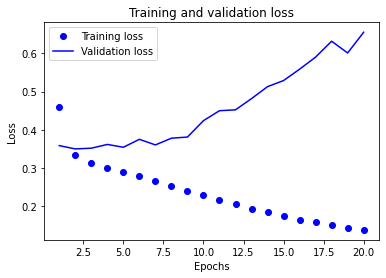

In [22]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')       # 'bo' 는 파란색 점
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')  # 'b' 는 파란색 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

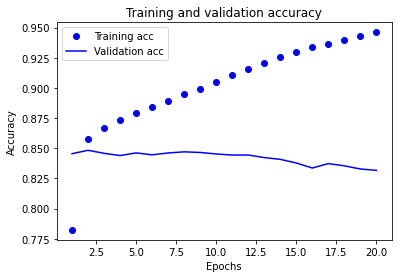

In [23]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 1-D CNN(1-D Convolution Neural Network)

In [24]:
vocab_size = 10000       # 어휘 사전의 크기
word_vector_dim = 16     # 단어 하나를 표현하는 임베딩 벡터의 차원 수

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16,7, activation = 'relu'))   # Conv1D(필터의 개수, 필터 사이즈, 활성화 함수)
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16,7, activation = 'relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160000    
                                                                 
 conv1d (Conv1D)             (None, None, 16)          1808      
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)                

In [25]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

epochs = 20

history = model.fit(X_train,
                    y_train,
                    epochs = epochs,
                    batch_size = 512,
                    validation_data = (X_val,y_val),
                    verbose = 1)

Epoch 1/20
229/229 [==============================] - 6s 7ms/step - loss: 0.4977 - accuracy: 0.7529 - val_loss: 0.3581 - val_accuracy: 0.8425
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3266 - accuracy: 0.8605 - val_loss: 0.3497 - val_accuracy: 0.8450
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2926 - accuracy: 0.8787 - val_loss: 0.3449 - val_accuracy: 0.8514
Epoch 4/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2648 - accuracy: 0.8924 - val_loss: 0.3507 - val_accuracy: 0.8484
Epoch 5/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2351 - accuracy: 0.9078 - val_loss: 0.3644 - val_accuracy: 0.8475
Epoch 6/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2020 - accuracy: 0.9242 - val_loss: 0.3866 - val_accuracy: 0.8456
Epoch 7/20
229/229 [==============================] - 1s 6ms/step - loss: 0.1691 - accuracy: 0.9391 - val_loss: 0.4204 - val_accuracy: 0.8419
Epoch 

In [26]:
results = model.evaluate(X_test,y_test, verbose =2)
print(results)

1537/1537 - 3s - loss: 0.9638 - accuracy: 0.8160 - 3s/epoch - 2ms/step
[0.9638122320175171, 0.8160384297370911]


In [27]:
history_dict = history.history

print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


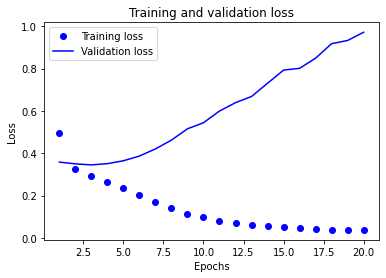

In [28]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

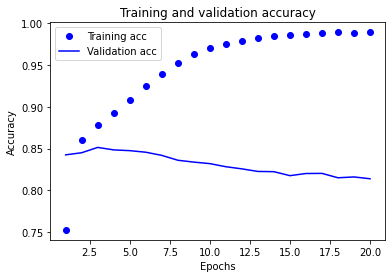

In [29]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## GlobalMaxPooling1D

In [30]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160000    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

epochs = 20

history = model.fit(X_train,
                    y_train,
                    epochs = epochs,
                    batch_size = 512,
                    validation_data = (X_val,y_val),
                    verbose = 1)

Epoch 1/20
229/229 [==============================] - 2s 5ms/step - loss: 0.6167 - accuracy: 0.7125 - val_loss: 0.4833 - val_accuracy: 0.8114
Epoch 2/20
229/229 [==============================] - 1s 5ms/step - loss: 0.4025 - accuracy: 0.8342 - val_loss: 0.3753 - val_accuracy: 0.8365
Epoch 3/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3334 - accuracy: 0.8600 - val_loss: 0.3590 - val_accuracy: 0.8423
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3017 - accuracy: 0.8752 - val_loss: 0.3580 - val_accuracy: 0.8442
Epoch 5/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2793 - accuracy: 0.8855 - val_loss: 0.3621 - val_accuracy: 0.8439
Epoch 6/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2617 - accuracy: 0.8949 - val_loss: 0.3690 - val_accuracy: 0.8421
Epoch 7/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2466 - accuracy: 0.9021 - val_loss: 0.3773 - val_accuracy: 0.8415
Epoch 

In [32]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


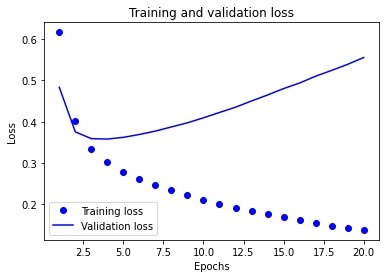

In [33]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

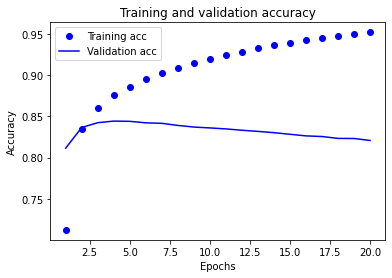

In [34]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Word2Vec

In [35]:
!pip list | grep gensim

gensim                        3.6.0


In [36]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)  # shape : (vocab_size, embedding_dim)

(10000, 16)


In [37]:
import os
os.environ["HOME"]=''
print(os.getenv("HOME"))

In [38]:
# 학습한 Ebdding 파라미터를 파일에 써서 저장한다.
word2vec_file_path = os.getenv('HOME')+'/content/drive/MyDrive/Exploration/Exploration_8/data/word2vec_ex.txt'
f = open(word2vec_file_path, 'w')
# 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 쓴다.
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

# 단어 개수(특수문자 4개를 제외하고) 만큼의 워드 벡터를 파일에 기록한다.
vectors = model.get_weights()[0]
for i in range(4, vocab_size):
  f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str,list(vectors[i, :])))))
f.close()

## 유사단어 활용 - 자체학습

In [39]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary =False)
vector = word_vectors['영화']
vector

array([-0.35916945, -0.18255557, -0.18509816, -0.09794702, -0.30595642,
       -0.23197788, -0.30066332, -0.12440263, -0.23671225, -0.2830224 ,
       -0.25138015, -0.22458641, -0.280351  , -0.25442258, -0.24971615,
       -0.26817784], dtype=float32)

In [40]:
word_vectors.similar_by_word('영화')

[('고', 0.9838423728942871),
 ('', 0.9811532497406006),
 ('.', 0.9779554009437561),
 ('하', 0.9746155738830566),
 ('몇', 0.9740772843360901),
 ('는데', 0.9694559574127197),
 ('음', 0.9652615785598755),
 ('어', 0.9632231593132019),
 ('(', 0.9621460437774658),
 ('다', 0.9611601233482361)]

## 유사단어 활용 - 사전학습 임베딩 활용

In [41]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/content/drive/MyDrive/Exploration/Exploration_8/data/word2vec_ko.model'

In [42]:
from gensim.models import Word2Vec

word2vec = Word2Vec.load(word2vec_path)
vector = word2vec['영화']
vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


array([-1.8007389 , -1.1790098 , -2.4066596 ,  2.1384156 , -0.3537603 ,
        1.3749527 , -4.894612  , -3.6517198 ,  0.4411444 ,  0.78153926,
       -2.696888  , -1.7812852 , -2.1514654 , -4.813236  ,  2.7465918 ,
       -2.1620324 , -0.11467794, -1.2431171 ,  2.3979309 , -1.1060628 ,
       -0.41043055,  1.9500391 ,  0.7821002 ,  1.5899978 ,  1.6447444 ,
       -2.1265035 , -1.7981595 ,  1.7535795 ,  0.53717697, -1.212121  ,
       -4.466316  ,  4.5488324 ,  1.334441  , -0.9070271 ,  1.1931889 ,
        4.1563215 ,  1.9758307 , -0.9437562 , -0.2592725 ,  0.34935686,
        1.8562875 , -3.3249645 ,  1.1221625 ,  1.2836524 ,  3.9211376 ,
        3.8023994 ,  2.766269  ,  0.67293745,  2.2853644 , -5.1131716 ,
        0.32525915, -3.3079958 ,  5.3043513 , -3.8813758 , -0.32960036,
       -1.9527504 ,  3.8865075 , -3.5470378 , -0.21991685,  0.82119733,
       -0.9492492 ,  3.5472107 ,  1.322048  , -0.70640826,  0.52253807,
        1.4683235 , -1.1018689 ,  2.262941  , -0.7204685 , -1.76

In [43]:
word2vec.similar_by_word("영화")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('드라마', 0.8418774008750916),
 ('뮤지컬', 0.7775139808654785),
 ('코미디', 0.7489107251167297),
 ('다큐멘터리', 0.7401294708251953),
 ('헐리우드', 0.7397844791412354),
 ('애니메이션', 0.7170552015304565),
 ('독립영화', 0.7113527655601501),
 ('로맨틱', 0.7107658386230469),
 ('장편', 0.7101576328277588),
 ('극영화', 0.7045413255691528)]

In [44]:
vector.shape

(100,)

In [63]:
vocab_size = 10000
word_vector_dim = 100
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_metrix 에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
  if index_to_word[i] in word2vec:
    embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


## RNN(LSTM)

In [76]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(512))   
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))


model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 41, 100)           1000000   
                                                                 
 lstm_4 (LSTM)               (None, 512)               1255424   
                                                                 
 dense_18 (Dense)            (None, 64)                32832     
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,288,321
Trainable params: 2,288,321
Non-trainable params: 0
_________________________________________________________________


In [77]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [78]:
history = model.fit(X_train,
                    y_train,
                    epochs=3,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/3
7310/7310 [==============================] - 70s 9ms/step - loss: 0.4031 - accuracy: 0.8126 - val_loss: 0.3391 - val_accuracy: 0.8513
Epoch 2/3
7310/7310 [==============================] - 67s 9ms/step - loss: 0.3014 - accuracy: 0.8712 - val_loss: 0.3301 - val_accuracy: 0.8574
Epoch 3/3
7310/7310 [==============================] - 63s 9ms/step - loss: 0.2549 - accuracy: 0.8945 - val_loss: 0.3385 - val_accuracy: 0.8575


In [79]:
results = model.evaluate(X_test, y_test, verbose = 2)
print(results)

1537/1537 - 5s - loss: 0.3402 - accuracy: 0.8570 - 5s/epoch - 3ms/step
[0.3401620090007782, 0.8570091724395752]


## 1-D CNN(1-D Convolution Neural Network)

In [69]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 4, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(4))
model.add(tf.keras.layers.Conv1D(16, 4, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 41, 100)           1000000   
                                                                 
 conv1d_4 (Conv1D)           (None, 38, 16)            6416      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 9, 16)            0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 6, 16)             1040      
                                                                 
 global_max_pooling1d_4 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_14 (Dense)            (None, 16)               

In [70]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [71]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
457/457 [==============================] - 4s 6ms/step - loss: 0.6190 - accuracy: 0.6381 - val_loss: 0.5408 - val_accuracy: 0.7227
Epoch 2/20
457/457 [==============================] - 3s 6ms/step - loss: 0.4956 - accuracy: 0.7528 - val_loss: 0.4742 - val_accuracy: 0.7670
Epoch 3/20
457/457 [==============================] - 3s 6ms/step - loss: 0.4321 - accuracy: 0.7961 - val_loss: 0.4420 - val_accuracy: 0.7899
Epoch 4/20
457/457 [==============================] - 3s 6ms/step - loss: 0.3941 - accuracy: 0.8189 - val_loss: 0.4265 - val_accuracy: 0.7987
Epoch 5/20
457/457 [==============================] - 3s 6ms/step - loss: 0.3692 - accuracy: 0.8329 - val_loss: 0.4174 - val_accuracy: 0.8045
Epoch 6/20
457/457 [==============================] - 3s 6ms/step - loss: 0.3488 - accuracy: 0.8443 - val_loss: 0.4189 - val_accuracy: 0.8079
Epoch 7/20
457/457 [==============================] - 3s 6ms/step - loss: 0.3315 - accuracy: 0.8533 - val_loss: 0.4180 - val_accuracy: 0.8072
Epoch 

In [72]:
results = model.evaluate(X_test, y_test, verbose = 2)
print(results)

1537/1537 - 3s - loss: 0.6169 - accuracy: 0.7939 - 3s/epoch - 2ms/step
[0.616912841796875, 0.7939255833625793]


## GlobalMaxPooling1D

In [54]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning

model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 41, 100)           1000000   
                                                                 
 global_max_pooling1d_3 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            (None, 16)                1616      
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,001,633
Trainable params: 1,001,633
Non-trainable params: 0
_________________________________________________________________


In [55]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [56]:
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
914/914 [==============================] - 5s 5ms/step - loss: 0.6505 - accuracy: 0.6251 - val_loss: 0.5994 - val_accuracy: 0.6733
Epoch 2/10
914/914 [==============================] - 4s 5ms/step - loss: 0.5615 - accuracy: 0.7084 - val_loss: 0.5342 - val_accuracy: 0.7286
Epoch 3/10
914/914 [==============================] - 4s 5ms/step - loss: 0.5063 - accuracy: 0.7498 - val_loss: 0.5129 - val_accuracy: 0.7436
Epoch 4/10
914/914 [==============================] - 4s 5ms/step - loss: 0.4689 - accuracy: 0.7747 - val_loss: 0.4724 - val_accuracy: 0.7725
Epoch 5/10
914/914 [==============================] - 4s 5ms/step - loss: 0.4426 - accuracy: 0.7918 - val_loss: 0.4542 - val_accuracy: 0.7845
Epoch 6/10
914/914 [==============================] - 4s 4ms/step - loss: 0.4217 - accuracy: 0.8065 - val_loss: 0.4398 - val_accuracy: 0.7917
Epoch 7/10
914/914 [==============================] - 4s 4ms/step - loss: 0.4049 - accuracy: 0.8152 - val_loss: 0.4299 - val_accuracy: 0.7995
Epoch 

In [57]:
results = model.evaluate(X_test, y_test, verbose = 2)
print(results)

1537/1537 - 3s - loss: 0.4215 - accuracy: 0.8088 - 3s/epoch - 2ms/step
[0.4214618504047394, 0.8087759613990784]


# 결론

  * 감성분석에 있어 여러가지 모델을 다루어 봤다. 특히, Word2Vec은 사전학습 임베딩을 활용하여 정확도를 높이는 작업은 의미가 있었다. 자체학습은 데이터가 부족하여, 유사 단어를 찾는 과정에 있어서 효과가 좋지 않았다. 또한, 모델 학습과정에서 알 수 있듯이, epochs을 늘린다고 모델의 효과가 좋아지지 않았다. 특히 이번 과정에서는 epochs 값을 낮게 하는 것이 더 유의미 했다.
  * Word2Vec 라이브러리를 이용하여 RNN (LSTM) 모델에서 85% 이상의 정확도를 달성했다.